### Survival Analysis  in Scikit Learn and XGBoost & Link XGBoost result to probability of survival by SkSuviv
https://github.com/sebp/scikit-survival

/Users/mpeng/Applications/anaconda3/envs/dev37/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Text(0.5, 0, 'time $t$')

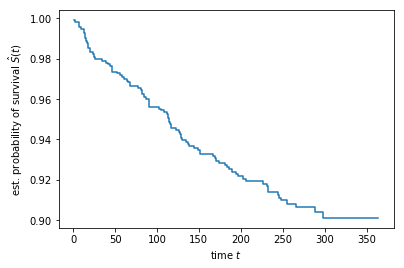

In [1]:
# y must be a structured array with the first field being a binary class event indicator 
# and the second field the time of the event/censoring

%matplotlib inline
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import scale
from sksurv.datasets import load_aids
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from numba import jit
import shap
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored


# load and inspect the data
data_x, data_y = load_aids()
data_x = data_x[list(np.setdiff1d(data_x.columns.values, ["hemophil"]))]
data_x_raw = data_x.copy()

if False:
    # change y value a bit and see how it goes
    data_y = np.array([list(x) for x in data_y])
    data_y = pd.DataFrame(data_y)
    data_y.columns = ['censor','time']
    data_y['censor'] = True
    data_y = np.core.records.fromarrays(data_y.values.transpose(), 
                                             names='censor, time',
                                             formats = '?,f8')

#time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
time, survival_prob = kaplan_meier_estimator(pd.DataFrame(data_y)['censor'].astype(np.bool), pd.DataFrame(data_y)['time'])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [2]:
display(data_x.head(), data_y)

,age,cd4,ivdrug,karnof,priorzdv,raceth,sex,strat2,tx,txgrp
0,34.0,169.0,1,100,39.0,1,1,1,0,1
1,34.0,149.5,1,90,15.0,2,2,1,0,1
2,20.0,23.5,1,100,9.0,1,1,0,1,2
3,48.0,46.0,1,90,53.0,1,1,1,0,1
4,46.0,10.0,3,90,12.0,1,1,0,1,2


array([(False, 189.), (False, 287.), (False, 242.), ..., (False, 272.),
       (False, 192.), (False, 132.)],
      dtype=[('censor', '?'), ('time', '<f8')])

In [3]:
# Since XGBoost only allow one column for y, the censoring information is coded as negative values:
data_y_xgb = np.array([x[1] if x[0] else -x[1] for x in data_y])
data_y_xgb[10:15]

array([-334., -285., -265.,  206., -305.])

In [4]:
# Since sksurv output log hazard ratios (here relative to 0 on predictors) 
# we must use 'output_margin=True' for comparability.
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.33, random_state=42)
# Train Test index split
train_idx, test_idx = train_test_split(np.arange(len(data_x)), test_size=0.33, random_state=42)

if data_x.__class__ != np.ndarray:
    data_x = data_x.astype(np.float).values # convert data_x into matrix
    #data_x = scale(data_x, axis=0, with_mean=True, with_std=True, copy=True ) # scale X-matrix

estimator = CoxPHSurvivalAnalysis(alpha=50, n_iter=10000000).fit(data_x[train_idx], data_y[train_idx])
gbm1 = xgb.XGBRegressor(objective='survival:cox',
                       booster='gblinear', base_score=1,
                       reg_alpha=0.01, reg_lambda=0.01,
                       n_estimators=10000,
                       n_jobs=-1,
                       ).fit(data_x[train_idx], data_y_xgb[train_idx])

params = {"eta": 0.001, "max_depth": 2, "objective": "survival:cox", "subsample": 0.85,
          "base_score": 1, "alpha":0.01, "lambda":0.001, "min_child_weight":2,
         "booster":'gbtree'}

dtrain = xgb.DMatrix(data_x[train_idx], label=data_y_xgb[train_idx])
dtest = xgb.DMatrix(data_x[test_idx], label=data_y_xgb[test_idx])
gbm2 = xgb.train(params, dtrain, num_boost_round=10000, 
                 evals = [(dtrain, "train"), (dtest, "test")], 
                 verbose_eval=True, early_stopping_rounds=100,
                 callbacks=[xgb.callback.print_evaluation(period=10, show_stdv=True)])

# Predictions
prediction_sksurv_train = estimator.predict(data_x[train_idx])
predictions_xgb1_train = gbm1.predict(data_x[train_idx], output_margin=True)
predictions_xgb2_train = gbm2.predict(dtrain, output_margin=True)
d = pd.DataFrame({'xgb1': predictions_xgb1_train,
                  'sksurv': prediction_sksurv_train,
                  "xgb2": predictions_xgb2_train})
# check if predicts by xgboost can be used in survival function
predictions_xgb2_train.shape = (predictions_xgb2_train.shape[0],1)
prediction_mix_train = CoxPHSurvivalAnalysis(alpha=0).fit(predictions_xgb2_train, 
                                            data_y[train_idx]).predict(predictions_xgb2_train)
d['xgb_plus_sksurv'] = prediction_mix_train

[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	train-cox-nloglik:6.44903	test-cox-nloglik:5.76746
[0]	train-cox-nloglik:6.44903	test-cox-nloglik:5.76746
Multiple eval metrics have been passed: 'test-cox-nloglik' will be used for early stopping.

Will train until test-cox-nloglik hasn't improved in 100 rounds.
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	train-cox-nloglik:6.44811	test-cox-nloglik:5.76673
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	train-cox-nloglik:6.44709	test-cox-nloglik:5.76563
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	train-cox-nloglik:6.44604	test-cox-nloglik:5.76484
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	train-co

[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[47]	train-cox-nloglik:6.40754	test-cox-nloglik:5.73193
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[48]	train-cox-nloglik:6.40673	test-cox-nloglik:5.73104
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[49]	train-cox-nloglik:6.40587	test-cox-nloglik:5.7305
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[50]	train-cox-nloglik:6.40497	test-cox-nloglik:5.72949
[50]	train-cox-nloglik:6.40497	test-cox-nloglik:5.72949
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[51]	train-cox-nloglik:6.40421	test-cox-nloglik:5.72872
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2

[94]	train-cox-nloglik:6.36949	test-cox-nloglik:5.69729
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[95]	train-cox-nloglik:6.36864	test-cox-nloglik:5.69665
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[96]	train-cox-nloglik:6.36795	test-cox-nloglik:5.69631
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[97]	train-cox-nloglik:6.36713	test-cox-nloglik:5.69571
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[98]	train-cox-nloglik:6.36653	test-cox-nloglik:5.6953
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[99]	train-cox-nloglik:6.36561	test-cox-nloglik:5.69464
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2

[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[142]	train-cox-nloglik:6.33468	test-cox-nloglik:5.66753
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[143]	train-cox-nloglik:6.33402	test-cox-nloglik:5.66686
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[144]	train-cox-nloglik:6.33326	test-cox-nloglik:5.66607
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[145]	train-cox-nloglik:6.33254	test-cox-nloglik:5.66533
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[146]	train-cox-nloglik:6.33181	test-cox-nloglik:5.66449
[05:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[147]	train-cox-nloglik:6.33118	test-cox-nloglik:

[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[190]	train-cox-nloglik:6.30356	test-cox-nloglik:5.64148
[190]	train-cox-nloglik:6.30356	test-cox-nloglik:5.64148
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[191]	train-cox-nloglik:6.30297	test-cox-nloglik:5.64124
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[192]	train-cox-nloglik:6.30234	test-cox-nloglik:5.64078
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[193]	train-cox-nloglik:6.30168	test-cox-nloglik:5.64027
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[194]	train-cox-nloglik:6.30107	test-cox-nloglik:5.63984
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_

[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[238]	train-cox-nloglik:6.27309	test-cox-nloglik:5.61625
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[239]	train-cox-nloglik:6.27252	test-cox-nloglik:5.61591
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[240]	train-cox-nloglik:6.27198	test-cox-nloglik:5.61567
[240]	train-cox-nloglik:6.27198	test-cox-nloglik:5.61567
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[241]	train-cox-nloglik:6.27147	test-cox-nloglik:5.61532
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[242]	train-cox-nloglik:6.27085	test-cox-nloglik:5.61479
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_

[285]	train-cox-nloglik:6.24739	test-cox-nloglik:5.5963
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[286]	train-cox-nloglik:6.247	test-cox-nloglik:5.59609
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[287]	train-cox-nloglik:6.24637	test-cox-nloglik:5.59535
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[288]	train-cox-nloglik:6.24593	test-cox-nloglik:5.59506
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[289]	train-cox-nloglik:6.24539	test-cox-nloglik:5.59458
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[290]	train-cox-nloglik:6.24489	test-cox-nloglik:5.59426
[290]	train-cox-nloglik:6.24489	test-cox-nloglik:5.59426
[05:11:20] src/tree/updater_prune.cc:74: tree pru

[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[333]	train-cox-nloglik:6.2227	test-cox-nloglik:5.57655
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[334]	train-cox-nloglik:6.22222	test-cox-nloglik:5.57609
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[335]	train-cox-nloglik:6.22175	test-cox-nloglik:5.57578
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[336]	train-cox-nloglik:6.22126	test-cox-nloglik:5.57566
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[337]	train-cox-nloglik:6.22074	test-cox-nloglik:5.57519
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[338]	train-cox-nloglik:6.22037	test-cox-nloglik:5

[380]	train-cox-nloglik:6.20033	test-cox-nloglik:5.56151
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[381]	train-cox-nloglik:6.19982	test-cox-nloglik:5.56096
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[382]	train-cox-nloglik:6.19929	test-cox-nloglik:5.56061
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[383]	train-cox-nloglik:6.19881	test-cox-nloglik:5.56011
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[384]	train-cox-nloglik:6.19835	test-cox-nloglik:5.55965
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[385]	train-cox-nloglik:6.1979	test-cox-nloglik:5.55935
[05:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_d

[428]	train-cox-nloglik:6.1779	test-cox-nloglik:5.54382
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[429]	train-cox-nloglik:6.17741	test-cox-nloglik:5.54343
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[430]	train-cox-nloglik:6.17688	test-cox-nloglik:5.54313
[430]	train-cox-nloglik:6.17688	test-cox-nloglik:5.54313
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[431]	train-cox-nloglik:6.1765	test-cox-nloglik:5.5429
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[432]	train-cox-nloglik:6.17609	test-cox-nloglik:5.54238
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[433]	train-cox-nloglik:6.17557	test-cox-nloglik:5.54217
[05:11:21] src/tree/updater_prune.cc:74: tree pru

[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[476]	train-cox-nloglik:6.15711	test-cox-nloglik:5.52967
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[477]	train-cox-nloglik:6.15672	test-cox-nloglik:5.52923
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[478]	train-cox-nloglik:6.15635	test-cox-nloglik:5.52913
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[479]	train-cox-nloglik:6.15587	test-cox-nloglik:5.52874
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[480]	train-cox-nloglik:6.15556	test-cox-nloglik:5.52865
[480]	train-cox-nloglik:6.15556	test-cox-nloglik:5.52865
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_

[523]	train-cox-nloglik:6.13851	test-cox-nloglik:5.51695
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[524]	train-cox-nloglik:6.13814	test-cox-nloglik:5.51665
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[525]	train-cox-nloglik:6.13774	test-cox-nloglik:5.51637
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[526]	train-cox-nloglik:6.13725	test-cox-nloglik:5.51601
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[527]	train-cox-nloglik:6.13679	test-cox-nloglik:5.51577
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[528]	train-cox-nloglik:6.13643	test-cox-nloglik:5.51554
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_

[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[571]	train-cox-nloglik:6.11994	test-cox-nloglik:5.50435
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[572]	train-cox-nloglik:6.11958	test-cox-nloglik:5.5041
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[573]	train-cox-nloglik:6.11906	test-cox-nloglik:5.5039
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[574]	train-cox-nloglik:6.11876	test-cox-nloglik:5.50364
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[575]	train-cox-nloglik:6.11839	test-cox-nloglik:5.50351
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[576]	train-cox-nloglik:6.11796	test-cox-nloglik:5.

[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[619]	train-cox-nloglik:6.10255	test-cox-nloglik:5.49362
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[620]	train-cox-nloglik:6.10216	test-cox-nloglik:5.49349
[620]	train-cox-nloglik:6.10216	test-cox-nloglik:5.49349
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[621]	train-cox-nloglik:6.10177	test-cox-nloglik:5.49334
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[622]	train-cox-nloglik:6.1014	test-cox-nloglik:5.49299
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[623]	train-cox-nloglik:6.10112	test-cox-nloglik:5.49292
[05:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_d

[666]	train-cox-nloglik:6.08643	test-cox-nloglik:5.48302
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[667]	train-cox-nloglik:6.08611	test-cox-nloglik:5.48278
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[668]	train-cox-nloglik:6.08577	test-cox-nloglik:5.48251
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[669]	train-cox-nloglik:6.08546	test-cox-nloglik:5.48233
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[670]	train-cox-nloglik:6.08518	test-cox-nloglik:5.48218
[670]	train-cox-nloglik:6.08518	test-cox-nloglik:5.48218
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[671]	train-cox-nloglik:6.08486	test-cox-nloglik:5.48203
[05:11:22] src/tree/updater_prune.cc:74: tree 

[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[714]	train-cox-nloglik:6.07172	test-cox-nloglik:5.47328
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[715]	train-cox-nloglik:6.07136	test-cox-nloglik:5.47317
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[716]	train-cox-nloglik:6.07107	test-cox-nloglik:5.47282
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[717]	train-cox-nloglik:6.07075	test-cox-nloglik:5.47257
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[718]	train-cox-nloglik:6.07036	test-cox-nloglik:5.47244
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[719]	train-cox-nloglik:6.06998	test-cox-nloglik:

[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[762]	train-cox-nloglik:6.05648	test-cox-nloglik:5.46322
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[763]	train-cox-nloglik:6.05621	test-cox-nloglik:5.46303
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[764]	train-cox-nloglik:6.05596	test-cox-nloglik:5.46274
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[765]	train-cox-nloglik:6.05557	test-cox-nloglik:5.46256
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[766]	train-cox-nloglik:6.05528	test-cox-nloglik:5.46233
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[767]	train-cox-nloglik:6.05501	test-cox-nloglik:

[809]	train-cox-nloglik:6.04194	test-cox-nloglik:5.45476
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[810]	train-cox-nloglik:6.04167	test-cox-nloglik:5.45453
[810]	train-cox-nloglik:6.04167	test-cox-nloglik:5.45453
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[811]	train-cox-nloglik:6.04131	test-cox-nloglik:5.45445
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[812]	train-cox-nloglik:6.04103	test-cox-nloglik:5.45431
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[813]	train-cox-nloglik:6.04066	test-cox-nloglik:5.45422
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[814]	train-cox-nloglik:6.04031	test-cox-nloglik:5.45409
[05:11:22] src/tree/updater_prune.cc:74: tree 

[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[857]	train-cox-nloglik:6.02759	test-cox-nloglik:5.44658
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[858]	train-cox-nloglik:6.02718	test-cox-nloglik:5.44621
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[859]	train-cox-nloglik:6.02677	test-cox-nloglik:5.44605
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[860]	train-cox-nloglik:6.02652	test-cox-nloglik:5.44594
[860]	train-cox-nloglik:6.02652	test-cox-nloglik:5.44594
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[861]	train-cox-nloglik:6.02628	test-cox-nloglik:5.44579
[05:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_

[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[905]	train-cox-nloglik:6.01423	test-cox-nloglik:5.4383
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[906]	train-cox-nloglik:6.01391	test-cox-nloglik:5.43811
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[907]	train-cox-nloglik:6.01364	test-cox-nloglik:5.43799
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[908]	train-cox-nloglik:6.01335	test-cox-nloglik:5.43779
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[909]	train-cox-nloglik:6.01311	test-cox-nloglik:5.43752
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[910]	train-cox-nloglik:6.01291	test-cox-nloglik:5

[952]	train-cox-nloglik:6.00201	test-cox-nloglik:5.43124
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[953]	train-cox-nloglik:6.00178	test-cox-nloglik:5.43105
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[954]	train-cox-nloglik:6.0015	test-cox-nloglik:5.43085
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[955]	train-cox-nloglik:6.00123	test-cox-nloglik:5.43073
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[956]	train-cox-nloglik:6.001	test-cox-nloglik:5.43049
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[957]	train-cox-nloglik:6.00068	test-cox-nloglik:5.43023
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_dep

[1000]	train-cox-nloglik:5.98983	test-cox-nloglik:5.42378
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1001]	train-cox-nloglik:5.98961	test-cox-nloglik:5.42357
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1002]	train-cox-nloglik:5.9894	test-cox-nloglik:5.42349
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1003]	train-cox-nloglik:5.98913	test-cox-nloglik:5.42339
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1004]	train-cox-nloglik:5.98877	test-cox-nloglik:5.42308
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1005]	train-cox-nloglik:5.98846	test-cox-nloglik:5.42306
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes,

[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1048]	train-cox-nloglik:5.97786	test-cox-nloglik:5.41705
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1049]	train-cox-nloglik:5.97755	test-cox-nloglik:5.41697
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1050]	train-cox-nloglik:5.97732	test-cox-nloglik:5.41678
[1050]	train-cox-nloglik:5.97732	test-cox-nloglik:5.41678
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1051]	train-cox-nloglik:5.97696	test-cox-nloglik:5.41647
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1052]	train-cox-nloglik:5.97668	test-cox-nloglik:5.41641
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes

[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1095]	train-cox-nloglik:5.96668	test-cox-nloglik:5.41091
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1096]	train-cox-nloglik:5.96645	test-cox-nloglik:5.41087
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1097]	train-cox-nloglik:5.96624	test-cox-nloglik:5.41083
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1098]	train-cox-nloglik:5.96606	test-cox-nloglik:5.41073
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1099]	train-cox-nloglik:5.96584	test-cox-nloglik:5.41046
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1100]	train-cox-nloglik:5.9656	test-cox-nlo

[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1142]	train-cox-nloglik:5.95645	test-cox-nloglik:5.40551
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1143]	train-cox-nloglik:5.95623	test-cox-nloglik:5.40539
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1144]	train-cox-nloglik:5.95604	test-cox-nloglik:5.40523
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1145]	train-cox-nloglik:5.95576	test-cox-nloglik:5.40513
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1146]	train-cox-nloglik:5.95545	test-cox-nloglik:5.40495
[05:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1147]	train-cox-nloglik:5.95523	test-cox-nl

[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1190]	train-cox-nloglik:5.94574	test-cox-nloglik:5.4002
[1190]	train-cox-nloglik:5.94574	test-cox-nloglik:5.4002
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1191]	train-cox-nloglik:5.94548	test-cox-nloglik:5.40017
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1192]	train-cox-nloglik:5.94514	test-cox-nloglik:5.39987
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1193]	train-cox-nloglik:5.94494	test-cox-nloglik:5.39975
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1194]	train-cox-nloglik:5.94473	test-cox-nloglik:5.39964
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, 

[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1237]	train-cox-nloglik:5.93546	test-cox-nloglik:5.39503
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1238]	train-cox-nloglik:5.93521	test-cox-nloglik:5.39499
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1239]	train-cox-nloglik:5.93501	test-cox-nloglik:5.39477
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1240]	train-cox-nloglik:5.93479	test-cox-nloglik:5.3946
[1240]	train-cox-nloglik:5.93479	test-cox-nloglik:5.3946
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1241]	train-cox-nloglik:5.93456	test-cox-nloglik:5.39451
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, 

[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1284]	train-cox-nloglik:5.9255	test-cox-nloglik:5.38982
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1285]	train-cox-nloglik:5.92533	test-cox-nloglik:5.38973
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1286]	train-cox-nloglik:5.92516	test-cox-nloglik:5.38953
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1287]	train-cox-nloglik:5.92494	test-cox-nloglik:5.38941
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1288]	train-cox-nloglik:5.92472	test-cox-nloglik:5.38933
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1289]	train-cox-nloglik:5.92451	test-cox-nlo

[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1331]	train-cox-nloglik:5.91636	test-cox-nloglik:5.3848
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1332]	train-cox-nloglik:5.9161	test-cox-nloglik:5.38479
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1333]	train-cox-nloglik:5.91592	test-cox-nloglik:5.38464
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1334]	train-cox-nloglik:5.91575	test-cox-nloglik:5.38464
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1335]	train-cox-nloglik:5.91561	test-cox-nloglik:5.38453
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1336]	train-cox-nloglik:5.91541	test-cox-nlog

[1378]	train-cox-nloglik:5.90701	test-cox-nloglik:5.37936
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1379]	train-cox-nloglik:5.90686	test-cox-nloglik:5.37919
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1380]	train-cox-nloglik:5.90662	test-cox-nloglik:5.37911
[1380]	train-cox-nloglik:5.90662	test-cox-nloglik:5.37911
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1381]	train-cox-nloglik:5.90643	test-cox-nloglik:5.37904
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1382]	train-cox-nloglik:5.90623	test-cox-nloglik:5.37887
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1383]	train-cox-nloglik:5.90608	test-cox-nloglik:5.37881
[05:11:24] src/tree/updater_prune.cc:74

[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1426]	train-cox-nloglik:5.89748	test-cox-nloglik:5.37474
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1427]	train-cox-nloglik:5.89733	test-cox-nloglik:5.37471
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1428]	train-cox-nloglik:5.89711	test-cox-nloglik:5.37465
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1429]	train-cox-nloglik:5.89695	test-cox-nloglik:5.37466
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1430]	train-cox-nloglik:5.89668	test-cox-nloglik:5.37444
[1430]	train-cox-nloglik:5.89668	test-cox-nloglik:5.37444
[05:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes

[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1473]	train-cox-nloglik:5.88934	test-cox-nloglik:5.37043
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1474]	train-cox-nloglik:5.88907	test-cox-nloglik:5.37019
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1475]	train-cox-nloglik:5.88891	test-cox-nloglik:5.37005
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1476]	train-cox-nloglik:5.88871	test-cox-nloglik:5.36994
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1477]	train-cox-nloglik:5.88856	test-cox-nloglik:5.36983
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1478]	train-cox-nloglik:5.88835	test-cox-nl

[1520]	train-cox-nloglik:5.8809	test-cox-nloglik:5.36484
[1520]	train-cox-nloglik:5.8809	test-cox-nloglik:5.36484
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1521]	train-cox-nloglik:5.88067	test-cox-nloglik:5.36481
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1522]	train-cox-nloglik:5.8805	test-cox-nloglik:5.36467
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1523]	train-cox-nloglik:5.88035	test-cox-nloglik:5.36465
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1524]	train-cox-nloglik:5.88017	test-cox-nloglik:5.36455
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1525]	train-cox-nloglik:5.87998	test-cox-nloglik:5.36453
[05:11:25] src/tree/updater_prune.cc:74: t

[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1568]	train-cox-nloglik:5.87268	test-cox-nloglik:5.36153
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1569]	train-cox-nloglik:5.87248	test-cox-nloglik:5.36147
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1570]	train-cox-nloglik:5.87235	test-cox-nloglik:5.36138
[1570]	train-cox-nloglik:5.87235	test-cox-nloglik:5.36138
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1571]	train-cox-nloglik:5.87222	test-cox-nloglik:5.36139
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1572]	train-cox-nloglik:5.87209	test-cox-nloglik:5.3613
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes,

[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1615]	train-cox-nloglik:5.86376	test-cox-nloglik:5.35769
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1616]	train-cox-nloglik:5.86362	test-cox-nloglik:5.35754
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1617]	train-cox-nloglik:5.86341	test-cox-nloglik:5.35745
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1618]	train-cox-nloglik:5.86318	test-cox-nloglik:5.35735
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1619]	train-cox-nloglik:5.86303	test-cox-nloglik:5.35734
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1620]	train-cox-nloglik:5.86286	test-cox-nl

[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1662]	train-cox-nloglik:5.8554	test-cox-nloglik:5.35384
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1663]	train-cox-nloglik:5.85523	test-cox-nloglik:5.35383
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1664]	train-cox-nloglik:5.85499	test-cox-nloglik:5.35381
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1665]	train-cox-nloglik:5.85472	test-cox-nloglik:5.35357
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1666]	train-cox-nloglik:5.85449	test-cox-nloglik:5.35359
[05:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1667]	train-cox-nloglik:5.85428	test-cox-nlo

[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1710]	train-cox-nloglik:5.84678	test-cox-nloglik:5.35053
[1710]	train-cox-nloglik:5.84678	test-cox-nloglik:5.35053
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1711]	train-cox-nloglik:5.84665	test-cox-nloglik:5.35053
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1712]	train-cox-nloglik:5.84645	test-cox-nloglik:5.35064
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1713]	train-cox-nloglik:5.84631	test-cox-nloglik:5.35056
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1714]	train-cox-nloglik:5.84619	test-cox-nloglik:5.35047
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes

[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1757]	train-cox-nloglik:5.83941	test-cox-nloglik:5.34829
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1758]	train-cox-nloglik:5.83928	test-cox-nloglik:5.34812
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1759]	train-cox-nloglik:5.83908	test-cox-nloglik:5.34812
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1760]	train-cox-nloglik:5.83896	test-cox-nloglik:5.34798
[1760]	train-cox-nloglik:5.83896	test-cox-nloglik:5.34798
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1761]	train-cox-nloglik:5.83873	test-cox-nloglik:5.34799
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes

[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1804]	train-cox-nloglik:5.83124	test-cox-nloglik:5.34495
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1805]	train-cox-nloglik:5.8311	test-cox-nloglik:5.34479
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1806]	train-cox-nloglik:5.8309	test-cox-nloglik:5.34471
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1807]	train-cox-nloglik:5.83075	test-cox-nloglik:5.34464
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1808]	train-cox-nloglik:5.83059	test-cox-nloglik:5.34453
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1809]	train-cox-nloglik:5.83036	test-cox-nlog

[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1851]	train-cox-nloglik:5.82279	test-cox-nloglik:5.3406
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1852]	train-cox-nloglik:5.82267	test-cox-nloglik:5.34063
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1853]	train-cox-nloglik:5.82238	test-cox-nloglik:5.34042
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1854]	train-cox-nloglik:5.82211	test-cox-nloglik:5.34026
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1855]	train-cox-nloglik:5.82199	test-cox-nloglik:5.34015
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1856]	train-cox-nloglik:5.82188	test-cox-nlo

[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1899]	train-cox-nloglik:5.81478	test-cox-nloglik:5.33694
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1900]	train-cox-nloglik:5.81465	test-cox-nloglik:5.33684
[1900]	train-cox-nloglik:5.81465	test-cox-nloglik:5.33684
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1901]	train-cox-nloglik:5.81439	test-cox-nloglik:5.33663
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1902]	train-cox-nloglik:5.81413	test-cox-nloglik:5.33642
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1903]	train-cox-nloglik:5.81402	test-cox-nloglik:5.33643
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes

[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1946]	train-cox-nloglik:5.80722	test-cox-nloglik:5.3339
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1947]	train-cox-nloglik:5.80709	test-cox-nloglik:5.33385
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1948]	train-cox-nloglik:5.80683	test-cox-nloglik:5.33366
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1949]	train-cox-nloglik:5.80671	test-cox-nloglik:5.33365
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1950]	train-cox-nloglik:5.80653	test-cox-nloglik:5.33372
[1950]	train-cox-nloglik:5.80653	test-cox-nloglik:5.33372
[05:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes,

[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1993]	train-cox-nloglik:5.79955	test-cox-nloglik:5.33051
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1994]	train-cox-nloglik:5.79935	test-cox-nloglik:5.33045
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1995]	train-cox-nloglik:5.79925	test-cox-nloglik:5.33038
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1996]	train-cox-nloglik:5.79901	test-cox-nloglik:5.3302
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1997]	train-cox-nloglik:5.79884	test-cox-nloglik:5.33019
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1998]	train-cox-nloglik:5.79872	test-cox-nlo

[2040]	train-cox-nloglik:5.79258	test-cox-nloglik:5.32704
[2040]	train-cox-nloglik:5.79258	test-cox-nloglik:5.32704
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2041]	train-cox-nloglik:5.79247	test-cox-nloglik:5.32704
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2042]	train-cox-nloglik:5.79236	test-cox-nloglik:5.32707
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2043]	train-cox-nloglik:5.79215	test-cox-nloglik:5.32695
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2044]	train-cox-nloglik:5.79185	test-cox-nloglik:5.32679
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2045]	train-cox-nloglik:5.79176	test-cox-nloglik:5.32681
[05:11:27] src/tree/updater_prune.cc:74

[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2088]	train-cox-nloglik:5.78591	test-cox-nloglik:5.32563
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2089]	train-cox-nloglik:5.7857	test-cox-nloglik:5.32558
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2090]	train-cox-nloglik:5.78547	test-cox-nloglik:5.32569
[2090]	train-cox-nloglik:5.78547	test-cox-nloglik:5.32569
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2091]	train-cox-nloglik:5.78535	test-cox-nloglik:5.32558
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2092]	train-cox-nloglik:5.78508	test-cox-nloglik:5.32544
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes,

[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2135]	train-cox-nloglik:5.77915	test-cox-nloglik:5.32312
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2136]	train-cox-nloglik:5.77903	test-cox-nloglik:5.32296
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2137]	train-cox-nloglik:5.77895	test-cox-nloglik:5.32298
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2138]	train-cox-nloglik:5.77886	test-cox-nloglik:5.32293
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2139]	train-cox-nloglik:5.77867	test-cox-nloglik:5.32302
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2140]	train-cox-nloglik:5.77848	test-cox-nl

[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2182]	train-cox-nloglik:5.77271	test-cox-nloglik:5.32073
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2183]	train-cox-nloglik:5.7726	test-cox-nloglik:5.32063
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2184]	train-cox-nloglik:5.77249	test-cox-nloglik:5.3206
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2185]	train-cox-nloglik:5.77235	test-cox-nloglik:5.3206
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2186]	train-cox-nloglik:5.77225	test-cox-nloglik:5.32061
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2187]	train-cox-nloglik:5.77214	test-cox-nlogl

[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2230]	train-cox-nloglik:5.76591	test-cox-nloglik:5.31811
[2230]	train-cox-nloglik:5.76591	test-cox-nloglik:5.31811
[05:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2231]	train-cox-nloglik:5.76582	test-cox-nloglik:5.31814
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2232]	train-cox-nloglik:5.76561	test-cox-nloglik:5.31795
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2233]	train-cox-nloglik:5.76545	test-cox-nloglik:5.31794
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2234]	train-cox-nloglik:5.7653	test-cox-nloglik:5.3179
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, 

[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2277]	train-cox-nloglik:5.759	test-cox-nloglik:5.31525
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2278]	train-cox-nloglik:5.75886	test-cox-nloglik:5.31522
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2279]	train-cox-nloglik:5.75869	test-cox-nloglik:5.31518
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2280]	train-cox-nloglik:5.75858	test-cox-nloglik:5.31521
[2280]	train-cox-nloglik:5.75858	test-cox-nloglik:5.31521
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2281]	train-cox-nloglik:5.75842	test-cox-nloglik:5.31518
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, 

[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2324]	train-cox-nloglik:5.75248	test-cox-nloglik:5.31355
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2325]	train-cox-nloglik:5.75232	test-cox-nloglik:5.31363
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2326]	train-cox-nloglik:5.75224	test-cox-nloglik:5.31363
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2327]	train-cox-nloglik:5.75213	test-cox-nloglik:5.31348
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2328]	train-cox-nloglik:5.75201	test-cox-nloglik:5.31347
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2329]	train-cox-nloglik:5.75188	test-cox-nl

[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2371]	train-cox-nloglik:5.74602	test-cox-nloglik:5.31194
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2372]	train-cox-nloglik:5.74593	test-cox-nloglik:5.31192
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2373]	train-cox-nloglik:5.74584	test-cox-nloglik:5.31183
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2374]	train-cox-nloglik:5.74575	test-cox-nloglik:5.31177
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2375]	train-cox-nloglik:5.74559	test-cox-nloglik:5.31175
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2376]	train-cox-nloglik:5.74545	test-cox-nl

[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2419]	train-cox-nloglik:5.73874	test-cox-nloglik:5.30903
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2420]	train-cox-nloglik:5.73866	test-cox-nloglik:5.30906
[2420]	train-cox-nloglik:5.73866	test-cox-nloglik:5.30906
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2421]	train-cox-nloglik:5.73853	test-cox-nloglik:5.30904
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2422]	train-cox-nloglik:5.73836	test-cox-nloglik:5.30894
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2423]	train-cox-nloglik:5.73823	test-cox-nloglik:5.30898
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes

[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2466]	train-cox-nloglik:5.73213	test-cox-nloglik:5.30671
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2467]	train-cox-nloglik:5.732	test-cox-nloglik:5.30674
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2468]	train-cox-nloglik:5.7318	test-cox-nloglik:5.30667
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2469]	train-cox-nloglik:5.7317	test-cox-nloglik:5.30664
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2470]	train-cox-nloglik:5.73156	test-cox-nloglik:5.30663
[2470]	train-cox-nloglik:5.73156	test-cox-nloglik:5.30663
[05:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, ma

[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2513]	train-cox-nloglik:5.72579	test-cox-nloglik:5.30545
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2514]	train-cox-nloglik:5.72571	test-cox-nloglik:5.30532
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2515]	train-cox-nloglik:5.72561	test-cox-nloglik:5.3053
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2516]	train-cox-nloglik:5.72556	test-cox-nloglik:5.30523
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2517]	train-cox-nloglik:5.72544	test-cox-nloglik:5.30518
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2518]	train-cox-nloglik:5.72534	test-cox-nlo

[2560]	train-cox-nloglik:5.71963	test-cox-nloglik:5.30366
[2560]	train-cox-nloglik:5.71963	test-cox-nloglik:5.30366
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2561]	train-cox-nloglik:5.71954	test-cox-nloglik:5.3037
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2562]	train-cox-nloglik:5.71937	test-cox-nloglik:5.30376
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2563]	train-cox-nloglik:5.71925	test-cox-nloglik:5.30374
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2564]	train-cox-nloglik:5.71918	test-cox-nloglik:5.30375
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2565]	train-cox-nloglik:5.71909	test-cox-nloglik:5.30378
[05:11:29] src/tree/updater_prune.cc:74:

[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2608]	train-cox-nloglik:5.71328	test-cox-nloglik:5.3021
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2609]	train-cox-nloglik:5.71319	test-cox-nloglik:5.30198
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2610]	train-cox-nloglik:5.71305	test-cox-nloglik:5.30195
[2610]	train-cox-nloglik:5.71305	test-cox-nloglik:5.30195
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2611]	train-cox-nloglik:5.71297	test-cox-nloglik:5.30197
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2612]	train-cox-nloglik:5.7129	test-cox-nloglik:5.30199
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, 

[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2655]	train-cox-nloglik:5.70765	test-cox-nloglik:5.30102
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2656]	train-cox-nloglik:5.70744	test-cox-nloglik:5.30086
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2657]	train-cox-nloglik:5.70733	test-cox-nloglik:5.30075
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2658]	train-cox-nloglik:5.70714	test-cox-nloglik:5.30061
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2659]	train-cox-nloglik:5.70698	test-cox-nloglik:5.30058
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2660]	train-cox-nloglik:5.70692	test-cox-nl

[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2702]	train-cox-nloglik:5.70216	test-cox-nloglik:5.29894
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2703]	train-cox-nloglik:5.70196	test-cox-nloglik:5.29904
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2704]	train-cox-nloglik:5.70174	test-cox-nloglik:5.29898
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2705]	train-cox-nloglik:5.70166	test-cox-nloglik:5.29894
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2706]	train-cox-nloglik:5.70154	test-cox-nloglik:5.29899
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2707]	train-cox-nloglik:5.70146	test-cox-nl

[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2750]	train-cox-nloglik:5.6961	test-cox-nloglik:5.29793
[2750]	train-cox-nloglik:5.6961	test-cox-nloglik:5.29793
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2751]	train-cox-nloglik:5.69592	test-cox-nloglik:5.29778
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2752]	train-cox-nloglik:5.69579	test-cox-nloglik:5.29779
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2753]	train-cox-nloglik:5.69571	test-cox-nloglik:5.29773
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2754]	train-cox-nloglik:5.69557	test-cox-nloglik:5.29773
[05:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, 

[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2797]	train-cox-nloglik:5.69018	test-cox-nloglik:5.29636
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2798]	train-cox-nloglik:5.69003	test-cox-nloglik:5.29638
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2799]	train-cox-nloglik:5.68992	test-cox-nloglik:5.29655
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2800]	train-cox-nloglik:5.68985	test-cox-nloglik:5.29654
[2800]	train-cox-nloglik:5.68985	test-cox-nloglik:5.29654
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2801]	train-cox-nloglik:5.68961	test-cox-nloglik:5.29643
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes

[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2844]	train-cox-nloglik:5.68473	test-cox-nloglik:5.29585
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2845]	train-cox-nloglik:5.68464	test-cox-nloglik:5.29582
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2846]	train-cox-nloglik:5.68454	test-cox-nloglik:5.29595
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2847]	train-cox-nloglik:5.68446	test-cox-nloglik:5.29591
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2848]	train-cox-nloglik:5.68435	test-cox-nloglik:5.29597
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2849]	train-cox-nloglik:5.68424	test-cox-nl

[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2891]	train-cox-nloglik:5.67988	test-cox-nloglik:5.294
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2892]	train-cox-nloglik:5.67967	test-cox-nloglik:5.29386
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2893]	train-cox-nloglik:5.67959	test-cox-nloglik:5.29382
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2894]	train-cox-nloglik:5.67941	test-cox-nloglik:5.29378
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2895]	train-cox-nloglik:5.67934	test-cox-nloglik:5.29375
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2896]	train-cox-nloglik:5.67918	test-cox-nlog

[2938]	train-cox-nloglik:5.67476	test-cox-nloglik:5.29261
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2939]	train-cox-nloglik:5.67467	test-cox-nloglik:5.29261
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2940]	train-cox-nloglik:5.67451	test-cox-nloglik:5.29257
[2940]	train-cox-nloglik:5.67451	test-cox-nloglik:5.29257
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2941]	train-cox-nloglik:5.67437	test-cox-nloglik:5.29255
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2942]	train-cox-nloglik:5.67424	test-cox-nloglik:5.29254
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2943]	train-cox-nloglik:5.67416	test-cox-nloglik:5.29257
[05:11:30] src/tree/updater_prune.cc:74

[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2986]	train-cox-nloglik:5.66912	test-cox-nloglik:5.29222
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2987]	train-cox-nloglik:5.66897	test-cox-nloglik:5.29223
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2988]	train-cox-nloglik:5.66876	test-cox-nloglik:5.29215
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2989]	train-cox-nloglik:5.66868	test-cox-nloglik:5.29212
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2990]	train-cox-nloglik:5.66859	test-cox-nloglik:5.29208
[2990]	train-cox-nloglik:5.66859	test-cox-nloglik:5.29208
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes

[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3033]	train-cox-nloglik:5.66404	test-cox-nloglik:5.29173
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3034]	train-cox-nloglik:5.66388	test-cox-nloglik:5.29187
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3035]	train-cox-nloglik:5.66376	test-cox-nloglik:5.29187
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3036]	train-cox-nloglik:5.66363	test-cox-nloglik:5.29184
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3037]	train-cox-nloglik:5.66357	test-cox-nloglik:5.29185
[05:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3038]	train-cox-nloglik:5.66345	test-cox-nl

[3080]	train-cox-nloglik:5.65853	test-cox-nloglik:5.29064
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3081]	train-cox-nloglik:5.65841	test-cox-nloglik:5.2906
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3082]	train-cox-nloglik:5.65834	test-cox-nloglik:5.29057
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3083]	train-cox-nloglik:5.65826	test-cox-nloglik:5.29052
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3084]	train-cox-nloglik:5.6582	test-cox-nloglik:5.29046
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3085]	train-cox-nloglik:5.65808	test-cox-nloglik:5.29052
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, 

[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3128]	train-cox-nloglik:5.65322	test-cox-nloglik:5.28969
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3129]	train-cox-nloglik:5.65314	test-cox-nloglik:5.2896
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3130]	train-cox-nloglik:5.65292	test-cox-nloglik:5.28948
[3130]	train-cox-nloglik:5.65292	test-cox-nloglik:5.28948
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3131]	train-cox-nloglik:5.65286	test-cox-nloglik:5.28946
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3132]	train-cox-nloglik:5.6527	test-cox-nloglik:5.28935
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, 

[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3175]	train-cox-nloglik:5.64828	test-cox-nloglik:5.28867
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3176]	train-cox-nloglik:5.64823	test-cox-nloglik:5.28862
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3177]	train-cox-nloglik:5.6481	test-cox-nloglik:5.28863
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3178]	train-cox-nloglik:5.64794	test-cox-nloglik:5.28852
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3179]	train-cox-nloglik:5.64783	test-cox-nloglik:5.28847
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3180]	train-cox-nloglik:5.64769	test-cox-nlo

[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3222]	train-cox-nloglik:5.64351	test-cox-nloglik:5.28844
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3223]	train-cox-nloglik:5.64344	test-cox-nloglik:5.2884
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3224]	train-cox-nloglik:5.64325	test-cox-nloglik:5.28827
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3225]	train-cox-nloglik:5.64305	test-cox-nloglik:5.28818
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3226]	train-cox-nloglik:5.64299	test-cox-nloglik:5.28822
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3227]	train-cox-nloglik:5.64292	test-cox-nlo

[3269]	train-cox-nloglik:5.63851	test-cox-nloglik:5.28754
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3270]	train-cox-nloglik:5.63843	test-cox-nloglik:5.28748
[3270]	train-cox-nloglik:5.63843	test-cox-nloglik:5.28748
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3271]	train-cox-nloglik:5.63837	test-cox-nloglik:5.28744
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3272]	train-cox-nloglik:5.6383	test-cox-nloglik:5.2874
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3273]	train-cox-nloglik:5.63823	test-cox-nloglik:5.28736
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3274]	train-cox-nloglik:5.63804	test-cox-nloglik:5.28732
[05:11:31] src/tree/updater_prune.cc:74: 

[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3317]	train-cox-nloglik:5.6334	test-cox-nloglik:5.28707
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3318]	train-cox-nloglik:5.63327	test-cox-nloglik:5.28702
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3319]	train-cox-nloglik:5.63319	test-cox-nloglik:5.28695
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3320]	train-cox-nloglik:5.63305	test-cox-nloglik:5.28692
[3320]	train-cox-nloglik:5.63305	test-cox-nloglik:5.28692
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3321]	train-cox-nloglik:5.63296	test-cox-nloglik:5.2869
[05:11:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, 

[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3364]	train-cox-nloglik:5.62831	test-cox-nloglik:5.28627
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3365]	train-cox-nloglik:5.62824	test-cox-nloglik:5.28628
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3366]	train-cox-nloglik:5.62819	test-cox-nloglik:5.28633
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3367]	train-cox-nloglik:5.62801	test-cox-nloglik:5.28626
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3368]	train-cox-nloglik:5.62787	test-cox-nloglik:5.28623
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3369]	train-cox-nloglik:5.62778	test-cox-nl

[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3411]	train-cox-nloglik:5.62338	test-cox-nloglik:5.28537
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3412]	train-cox-nloglik:5.62326	test-cox-nloglik:5.28535
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3413]	train-cox-nloglik:5.62319	test-cox-nloglik:5.28531
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3414]	train-cox-nloglik:5.62313	test-cox-nloglik:5.28527
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3415]	train-cox-nloglik:5.62306	test-cox-nloglik:5.28531
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3416]	train-cox-nloglik:5.623	test-cox-nlog

[3458]	train-cox-nloglik:5.61845	test-cox-nloglik:5.28438
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3459]	train-cox-nloglik:5.61838	test-cox-nloglik:5.28442
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3460]	train-cox-nloglik:5.61823	test-cox-nloglik:5.28437
[3460]	train-cox-nloglik:5.61823	test-cox-nloglik:5.28437
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3461]	train-cox-nloglik:5.61811	test-cox-nloglik:5.2844
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3462]	train-cox-nloglik:5.61805	test-cox-nloglik:5.28442
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3463]	train-cox-nloglik:5.61789	test-cox-nloglik:5.28439
[05:11:32] src/tree/updater_prune.cc:74:

[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3506]	train-cox-nloglik:5.61389	test-cox-nloglik:5.28456
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3507]	train-cox-nloglik:5.61382	test-cox-nloglik:5.28461
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3508]	train-cox-nloglik:5.61376	test-cox-nloglik:5.28457
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3509]	train-cox-nloglik:5.61364	test-cox-nloglik:5.28477
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3510]	train-cox-nloglik:5.61355	test-cox-nloglik:5.28482
[3510]	train-cox-nloglik:5.61355	test-cox-nloglik:5.28482
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes

[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3553]	train-cox-nloglik:5.6092	test-cox-nloglik:5.28508
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3554]	train-cox-nloglik:5.60908	test-cox-nloglik:5.28511
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3555]	train-cox-nloglik:5.60898	test-cox-nloglik:5.28513
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3556]	train-cox-nloglik:5.60878	test-cox-nloglik:5.28524
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3557]	train-cox-nloglik:5.60868	test-cox-nloglik:5.28531
[05:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3558]	train-cox-nloglik:5.60861	test-cox-nlo

### Random search of hyper-parameters in XGBoost

In [5]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer

def coxval(y_true, y_pred):
    res = concordance_index_censored(y_true >0, np.abs(y_true), y_pred)
    # the higher the better one
    return res[0]

coxval_new = make_scorer(coxval)

params_sarch = {
        'min_child_weight': [2, 10],
        'gamma': [0],
        "reg_alpha": [0.1, 1],
        "reg_lambda":[0.1, 1],
        'subsample': [0.8],
        'max_depth': [2]
        }
    
my_fit_params = {   
    "early_stopping_rounds":20,
    "eval_set" : [[data_x[test_idx], data_y_xgb[test_idx]]],
    "verbose": 0
}

# random search's parameter:
# specify the
clf = xgb.XGBRegressor(learning_rate=0.1, objective='survival:cox', base_score=1,
                       n_estimators=1000, silent=True)    
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)
"""
random_search = RandomizedSearchCV(clf, param_distributions=params_sarch,
                                   n_iter=500, scoring=coxval_new,
                                   fit_params = my_fit_params,
                                   n_jobs=4, cv = 8,
                                   #cv=skf.split(data_x[train_idx], data_y_xgb[train_idx]), 
                                   verbose=3, random_state=1001)
"""
random_search = GridSearchCV(clf, param_grid=params_sarch, scoring=coxval_new,
                                   fit_params = my_fit_params,
                                   n_jobs=4, cv = 8, verbose=2)
res = random_search.fit(data_x[train_idx], data_y_xgb[train_idx])
res.best_params_, res.best_score_

Fitting 8 folds for each of 8 candidates, totalling 64 fits


/Users/mpeng/Applications/anaconda3/envs/dev37/lib/python3.6/site-packages/sklearn/model_selection/_search.py:585: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


[CV] gamma=0, max_depth=2, min_child_weight=2, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8 
[CV] gamma=0, max_depth=2, min_child_weight=2, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8 
[CV] gamma=0, max_depth=2, min_child_weight=2, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8 
[CV] gamma=0, max_depth=2, min_child_weight=2, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8 
[CV]  gamma=0, max_depth=2, min_child_weight=2, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8, total=   0.1s
[CV] gamma=0, max_depth=2, min_child_weight=2, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8 
[CV]  gamma=0, max_depth=2, min_child_weight=2, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8, total=   0.1s
[CV] gamma=0, max_depth=2, min_child_weight=2, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8 
[CV]  gamma=0, max_depth=2, min_child_weight=2, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8, total=   0.1s
[CV]  gamma=0, max_depth=2, min_child_weight=2, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8, total=   0.1s
[CV] gamma

[CV] gamma=0, max_depth=2, min_child_weight=10, reg_alpha=0.1, reg_lambda=1, subsample=0.8 
[CV]  gamma=0, max_depth=2, min_child_weight=10, reg_alpha=0.1, reg_lambda=1, subsample=0.8, total=   0.1s
[CV]  gamma=0, max_depth=2, min_child_weight=10, reg_alpha=0.1, reg_lambda=1, subsample=0.8, total=   0.1s
[CV] gamma=0, max_depth=2, min_child_weight=10, reg_alpha=0.1, reg_lambda=1, subsample=0.8 
[CV] gamma=0, max_depth=2, min_child_weight=10, reg_alpha=0.1, reg_lambda=1, subsample=0.8 
[CV]  gamma=0, max_depth=2, min_child_weight=10, reg_alpha=0.1, reg_lambda=1, subsample=0.8, total=   0.1s
[CV] gamma=0, max_depth=2, min_child_weight=10, reg_alpha=0.1, reg_lambda=1, subsample=0.8 
[CV]  gamma=0, max_depth=2, min_child_weight=10, reg_alpha=0.1, reg_lambda=1, subsample=0.8, total=   0.1s
[CV] gamma=0, max_depth=2, min_child_weight=10, reg_alpha=0.1, reg_lambda=1, subsample=0.8 
[CV]  gamma=0, max_depth=2, min_child_weight=10, reg_alpha=0.1, reg_lambda=1, subsample=0.8, total=   0.1s
[CV] 

[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:    2.1s finished


({'gamma': 0,
  'max_depth': 2,
  'min_child_weight': 10,
  'reg_alpha': 0.1,
  'reg_lambda': 0.1,
  'subsample': 0.8},
 0.7488054366301636)

Train: Cox Survival Regression has Concordance index 0.769
Train: XGboost GBLinear has Concordance index 0.764
Train: XGboost Boosting Tree Regression has Concordance index 0.85220494
Train: XGboost Boosting Tree + Survival Regression has Concordance index 0.85220494


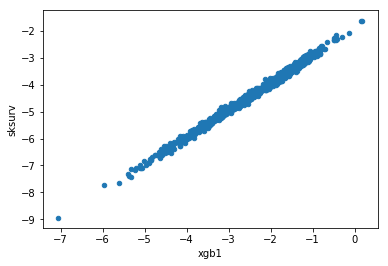

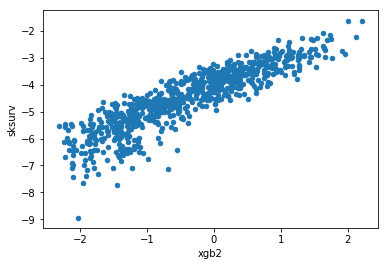

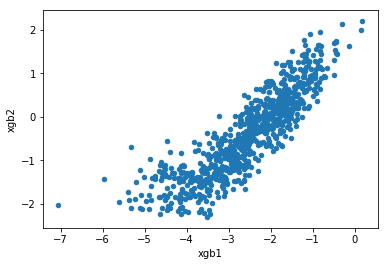

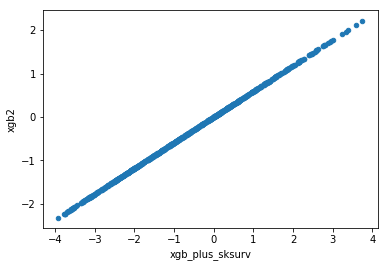

In [6]:
d.plot.scatter('xgb1','sksurv')
d.plot.scatter('xgb2','sksurv')
d.plot.scatter('xgb1','xgb2')
d.plot.scatter('xgb_plus_sksurv','xgb2')

result = concordance_index_censored(data_y["censor"][train_idx], data_y["time"][train_idx], prediction_sksurv_train)
print("Train: Cox Survival Regression has Concordance index {:.3}".format(result[0]))
result = concordance_index_censored(data_y["censor"][train_idx], data_y["time"][train_idx], predictions_xgb1_train)
print("Train: XGboost GBLinear has Concordance index {:.3}".format(result[0]))
result = concordance_index_censored(data_y["censor"][train_idx], data_y["time"][train_idx], predictions_xgb2_train[:,0])
print("Train: XGboost Boosting Tree Regression has Concordance index {:.8}".format(result[0]))
result = concordance_index_censored(data_y["censor"][train_idx], data_y["time"][train_idx], prediction_mix_train)
print("Train: XGboost Boosting Tree + Survival Regression has Concordance index {:.8}".format(result[0]))

## Show the result on 33% of test data

Test: Cox Survival Regression has Concordance index 0.793
Test: XGboost GBLinear has Concordance index 0.793
Test: XGboost Boosting Tree Regression has Concordance index 0.78004222
Test: XGboost Boosting Tree + Survival Regression has Concordance index 0.78004222
Test: Ensemble XGBoost+Survival has Concordance index 0.7882


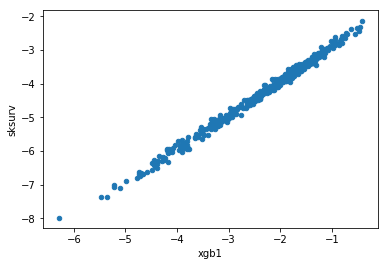

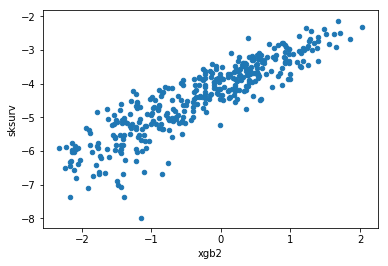

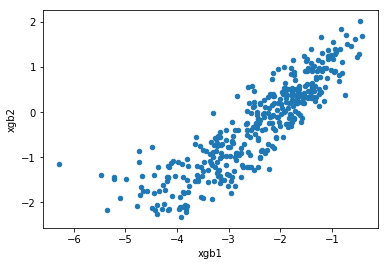

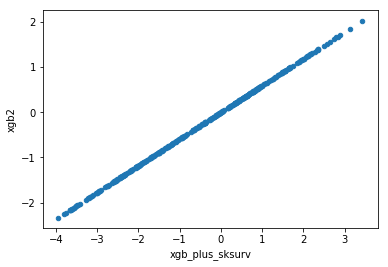

In [7]:
prediction_sksurv_test = estimator.predict(data_x[test_idx])
predictions_xgb1_test = gbm1.predict(data_x[test_idx], output_margin=True)
predictions_xgb2_test = gbm2.predict(dtest, output_margin=True)
d = pd.DataFrame({'xgb1': predictions_xgb1_test,
                  'sksurv': prediction_sksurv_test,
                  "xgb2": predictions_xgb2_test})
# check if predicts by xgboost can be used in survival function
predictions_xgb2_test.shape = (predictions_xgb2_test.shape[0],1)
prediction_mix_test = CoxPHSurvivalAnalysis(alpha=0).fit(predictions_xgb2_train, 
                                        data_y[train_idx]).predict(predictions_xgb2_test)
d['xgb_plus_sksurv'] = prediction_mix_test

d.plot.scatter('xgb1','sksurv')
d.plot.scatter('xgb2','sksurv')
d.plot.scatter('xgb1','xgb2')
d.plot.scatter('xgb_plus_sksurv','xgb2')

result = concordance_index_censored(data_y["censor"][test_idx], data_y["time"][test_idx], prediction_sksurv_test)
print("Test: Cox Survival Regression has Concordance index {:.3}".format(result[0]))
result = concordance_index_censored(data_y["censor"][test_idx], data_y["time"][test_idx], predictions_xgb1_test)
print("Test: XGboost GBLinear has Concordance index {:.3}".format(result[0]))
result = concordance_index_censored(data_y["censor"][test_idx], data_y["time"][test_idx], predictions_xgb2_test[:,0])
print("Test: XGboost Boosting Tree Regression has Concordance index {:.8}".format(result[0]))
result = concordance_index_censored(data_y["censor"][test_idx], data_y["time"][test_idx], prediction_mix_test)
print("Test: XGboost Boosting Tree + Survival Regression has Concordance index {:.8}".format(result[0]))
result = concordance_index_censored(data_y["censor"][test_idx], data_y["time"][test_idx], 0.5*predictions_xgb2_test[:,0]+0.5*prediction_sksurv_test)
print("Test: Ensemble XGBoost+Survival has Concordance index {:.4}".format(result[0]))

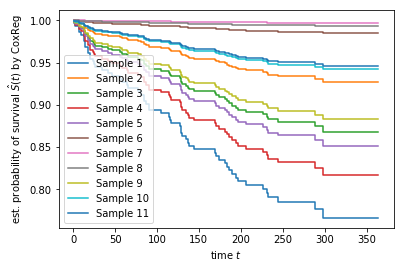

In [8]:
pred_surv = estimator.predict_survival_function(data_x[test_idx])
for i, c in enumerate(pred_surv):
    if i <= 10: # just print out the survival prob curve for first 6 samples
        plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
    else: break
plt.ylabel("est. probability of survival $\hat{S}(t)$ by CoxReg")
plt.xlabel("time $t$")
plt.legend(loc="best")

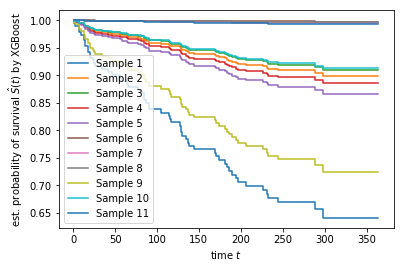

In [9]:
pred_surv = CoxPHSurvivalAnalysis(alpha=0).fit(predictions_xgb2_train, data_y[train_idx]).predict_survival_function(
                predictions_xgb2_test)
for i, c in enumerate(pred_surv):
    if i <= 10: # just print out the survival prob curve for first 6 samples
        plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
    else: break
plt.ylabel("est. probability of survival $\hat{S}(t)$ by XGBoost")
plt.xlabel("time $t$")
plt.legend(loc="best")

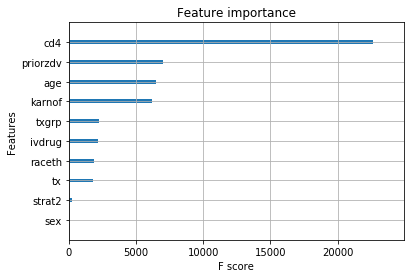

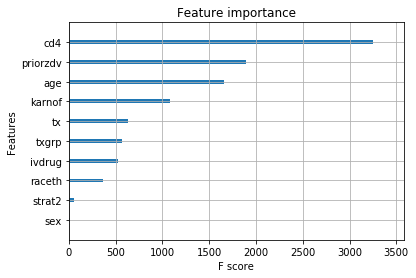

In [10]:
# Compute feature importance matrix
gbm2_copy = gbm2.copy()
gbm2.feature_names = list(data_x_raw.columns.values)
xgb.plot_importance(booster=gbm2, importance_type="total_gain", show_values=False)
xgb.plot_importance(booster=gbm2, importance_type="weight", show_values=False)

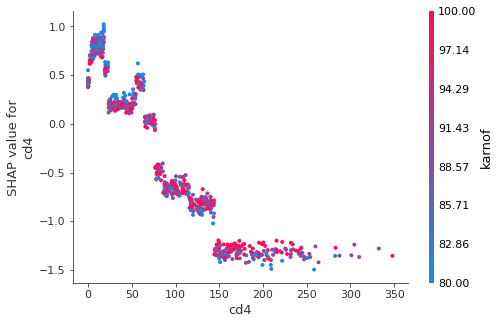

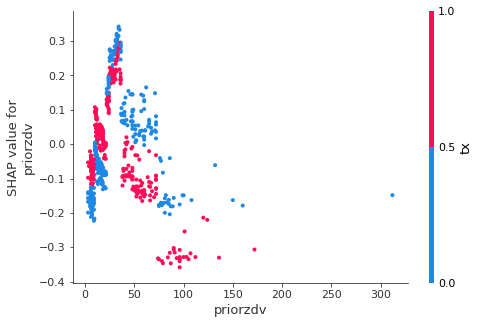

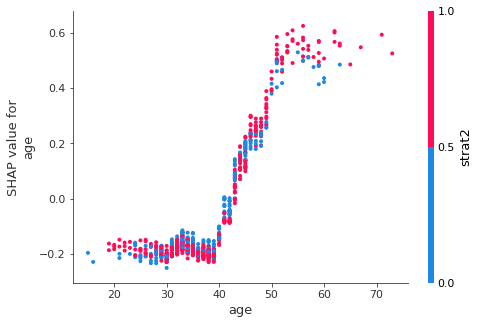

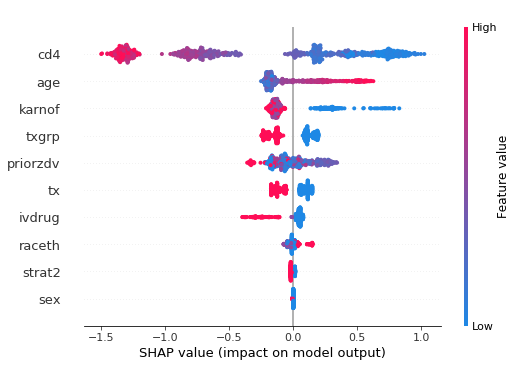

In [11]:
shap_values = shap.TreeExplainer(gbm2_copy).shap_values(data_x[train_idx])
shap.dependence_plot("cd4", shap_values, data_x_raw.iloc[train_idx].astype(np.float))
shap.dependence_plot("priorzdv", shap_values, data_x_raw.iloc[train_idx].astype(np.float))
shap.dependence_plot("age", shap_values, data_x_raw.iloc[train_idx].astype(np.float))
shap.summary_plot(shap_values, data_x[train_idx], feature_names=gbm2.feature_names)